# Variance comparison

In this notebook we compare the variances from a naive calculation, bootstrap and blocking.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from vmc.interface import *
from vmc import run_all

from IPython.core.pylabtools import figsize
from IPython.core.display import display

In [2]:
sns.set(color_codes=True)

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

step_length = 0.1
time_step = 0.1

alpha_min = 0.3
alpha_max = 0.7
num_alphas = 11

parameter_names = ["alpha"]

alphas = np.linspace(
    alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

num_particles = 10
num_dimensions = 3

bootstrap_samples = 0

num_samples_list = [int(2**i) for i in range(10, 22)]
num_thermalization_steps = 0

time_step_list = [8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]

In [4]:
# Iteration over different time steps. 
df_time_imp = {}
for time_step in time_step_list:
    
    sampler_imp = PySampler(
        PySimpleGaussian(
            num_particles, num_dimensions, mass, omega, spread=time_step),
        PyHarmonicOscillator(), PyMetropolisAlgorithm())
    
    kwargs = {
        "num_samples": 2**21, "step_length": time_step,
        "num_thermalization_steps": num_thermalization_steps,
        "sample_local_energies": True }
    
    df_imp = run_all(sampler_imp, alphas, parameter_names, bootstrap_samples, **kwargs)
    
    df_time_imp[time_step] = df_imp

100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


In [5]:
for key in df_time_imp:
    print("Time step: {:9} STD: {:6.5f} Acc': {:6.5f} Opt. E: {:6.5f}" 
          .format(
              key, 
              df_time_imp[key]['block_std'].mean(), 
              df_time_imp[key]['acceptance'].mean(),
              df_time_imp[key]['energy'][5]))

Time step:       8.0 STD: 0.03497 Acc': 0.00505 Opt. E: 15.00000
Time step:       4.0 STD: 0.01550 Acc': 0.04135 Opt. E: 15.00000
Time step:       2.0 STD: 0.00708 Acc': 0.21618 Opt. E: 15.00000
Time step:       1.0 STD: 0.00670 Acc': 0.51025 Opt. E: 15.00000
Time step:       0.5 STD: 0.00933 Acc': 0.73782 Opt. E: 15.00000
Time step:      0.25 STD: 0.01541 Acc': 0.86647 Opt. E: 15.00000
Time step:     0.125 STD: 0.02796 Acc': 0.93287 Opt. E: 15.00000
Time step:    0.0625 STD: 0.04896 Acc': 0.96641 Opt. E: 15.00000
Time step:   0.03125 STD: 0.08351 Acc': 0.98325 Opt. E: 15.00000
Time step:  0.015625 STD: 0.11992 Acc': 0.99183 Opt. E: 15.00000
Time step: 0.0078125 STD: 0.22139 Acc': 0.99606 Opt. E: 15.00000


In [6]:
df_time_imp

{0.0078125:     alpha     energy      variance       std  acceptance  sampling_time  \
 0    0.30  14.716687  1.657768e-06  0.001288    0.997269       0.829485   
 1    0.34  16.967407  4.811765e-06  0.002194    0.996421       0.821818   
 2    0.38  15.272658  1.022786e-06  0.001011    0.996430       0.729633   
 3    0.42  14.459273  1.900501e-07  0.000436    0.996785       0.730360   
 4    0.46  14.906015  5.806971e-08  0.000241    0.996304       0.727798   
 5    0.50  15.000000  0.000000e+00  0.000000    0.995791       0.736620   
 6    0.54  15.085986  8.738816e-08  0.000296    0.995752       0.732705   
 7    0.58  15.641672  1.429910e-07  0.000378    0.995867       0.764431   
 8    0.62  15.899788  3.786577e-07  0.000615    0.995688       0.750820   
 9    0.66  15.922795  7.367156e-07  0.000858    0.995358       0.770494   
 10   0.70  15.547990  2.325642e-06  0.001525    0.994995       0.828139   
 
     block_var  block_std  
 0    0.103803   0.322185  
 1    0.613949   0.

In [7]:
df_dict = {}

In [8]:
# Iteration over different number of MC cycles. 
for num_samples in num_samples_list:
    kwargs = {
        "num_samples": num_samples, "step_length": step_length,
        "num_thermalization_steps": num_thermalization_steps,
        "sample_local_energies": True}

    sampler_brute = PySampler(
        PySimpleGaussian(
            num_particles, num_dimensions, mass, omega, spread=step_length),
        PyHarmonicOscillator(), PyMetropolisAlgorithm())

    df_brute = run_all(sampler_brute, alphas, parameter_names, bootstrap_samples, **kwargs)

    sampler_imp = PySampler(
        PySimpleGaussian(
            num_particles, num_dimensions, mass, omega, spread=np.sqrt(time_step)),
        PyHarmonicOscillator(), PyImportanceMetropolis())

    kwargs["step_length"] = time_step
    
    df_imp = run_all(sampler_imp, alphas, parameter_names, bootstrap_samples, **kwargs)

    df_dict[num_samples] = [df_brute, df_imp]

100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


In [9]:
brute_variances = [df_dict[key][0]["block_var"].mean() for key in df_dict]
imp_variances = [df_dict[key][1]["block_var"].mean() for key in df_dict]

brute_energies = [df_dict[key][0]["energy"].mean() for key in df_dict]
imp_energies = [df_dict[key][1]["energy"].mean() for key in df_dict]

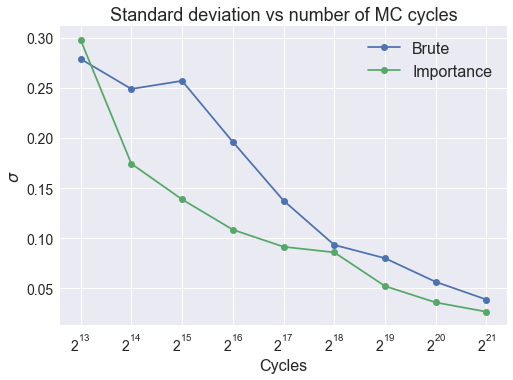

In [10]:
plt.plot(num_samples_list[3::], list(map(np.sqrt, brute_variances))[3::], "o-", label="Brute")
plt.plot(num_samples_list[3::], list(map(np.sqrt, imp_variances))[3::], "o-", label="Importance")
#plt.plot(num_samples_list, brute_variances, label="Brute")
#plt.plot(num_samples_list, imp_variances, label="Importance")
plt.xscale("log", basex=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.xlabel(r"Cycles", fontsize=16)
plt.ylabel(r"$\sigma$", fontsize=16)
plt.title("Standard deviation vs number of MC cycles", fontsize=18)
plt.savefig("problem_c1.pdf")
plt.show()

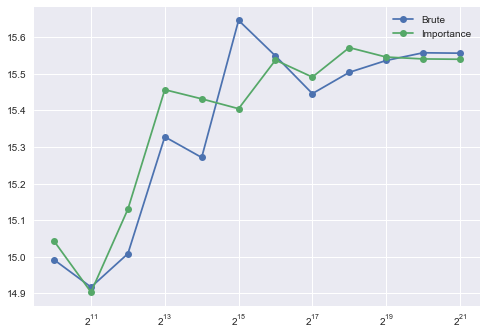

In [11]:
plt.plot(num_samples_list, brute_energies, "o-", label="Brute")
plt.plot(num_samples_list, imp_energies, "o-", label="Importance")
plt.xscale("log", basex=2)
plt.legend(loc="best")
plt.show()

In [12]:
wavefunction = PySimpleGaussian(
            10, num_dimensions, mass, omega, spread=step_length)
    
exact_energies = PyHarmonicOscillator().compute_exact_energy(wavefunction, alphas.ravel())

In [13]:
how_wrong_brute = []
how_wrong_imp = []
for key in df_dict:
    how_wrong_brute.append(np.abs(np.array(exact_energies) - np.array(df_dict[key][0]["energy"])))
    how_wrong_imp.append(np.abs(np.array(exact_energies) - np.array(df_dict[key][1]["energy"])))

In [14]:
how_wrong_brute_mean = [some_array.mean() for some_array in how_wrong_brute]
how_wrong_imp_mean = [some_array.mean() for some_array in how_wrong_imp] 

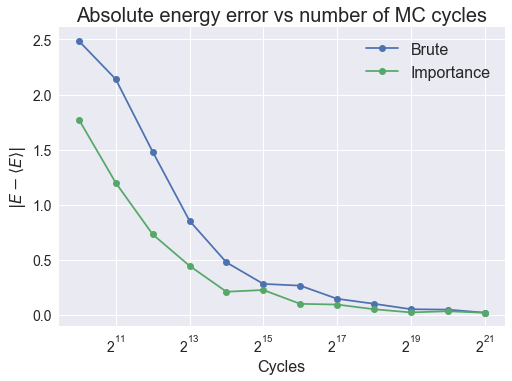

In [17]:
plt.plot(num_samples_list, how_wrong_brute_mean, "o-", label="Brute")
plt.plot(num_samples_list, how_wrong_imp_mean, "o-", label="Importance")
plt.title("Absolute energy error vs number of MC cycles", fontsize=20)
plt.xlabel("Cycles", fontsize=16)
plt.ylabel(r"$|E - \langle E \rangle|$", fontsize=16)
plt.xscale("log", basex=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.savefig("problem_c2.pdf")
plt.show()